# Evaluation of Learned Decoder
The purpose of this notebook is to evaluate the effectiveness of the learned decoders from CNN and GAN

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
import torchvision.transforms as transforms
import torch
from torch.utils.data import DataLoader

import wandb
import datetime
desktop_path = '/Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
laptop_path = '/Users/jocelynornelas/iCloud Drive (Archive)/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/'
if desktop_path in sys.path[0]: sys.path.insert(0, desktop_path + 'lib/'); path = desktop_path
elif laptop_path in sys.path[0]: sys.path.insert(0, laptop_path + 'lib/'); path = laptop_path
print('Using path = ', path)

from dataset import MNIST_MURA, FashionMURA
from utils.data import load_data
from utils.transforms import Noise_dB, Normalize_01
from reconstruct import RECON_CNN
# # Change plotting parameters
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "Times", #"Computer Modern Serif"
#     "figure.figsize" : [15,10],
# })

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Log into WandB
# wandb.login()

Using path =  /Users/jornelasmunoz/Desktop/UC Merced/Research/coded-aperture/jornelasmunoz/
Using cpu device


In [3]:
# Log into WandB for logging project training runs
wandb.login()

wandb: Currently logged in as: jocelynornelasmunoz. Use `wandb login --relogin` to force relogin


True

In [6]:
# Create params dict
date = '2024-01-25'#str(datetime.datetime.now().date())
params = {
    "image_size": 47,
    "batch_size":100,
    "learning_rate": 0.001, 
    "epochs": 5,
    "model": f"decoder_cnn_{date}",
    "dataset": "fashion_mura_noiseless",
    "scheduler_patience": 1,
    "snr": None, 
}

if params['image_size'] != 23:
    params['model'] = f"decoder_cnn_{date}_{params['image_size']}x{params['image_size']}_{params['dataset']}"
wandb.config = params

# Load data
train_data, test_data, loaders = load_data(params)

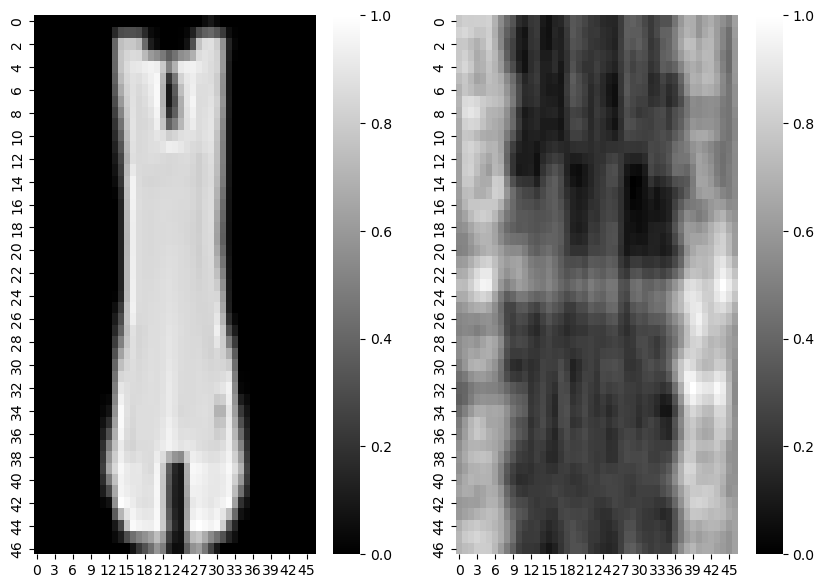

In [7]:
# Visualize data
fig, axs = plt.subplots(1,2, figsize=(10,7))
idx=4
sns.heatmap(loaders['train'].dataset[idx]['target'].squeeze(0), cmap= 'gray', ax=axs[0])
sns.heatmap(loaders['train'].dataset[idx]['img'].squeeze(0), cmap= 'gray', ax=axs[1])
# axs[0].axis('off')
# axs[1].axis('off')
plt.show()

# Define Model

In [10]:
# Instantiate model 
model = RECON_CNN(params)#.to(device)
# model.apply(model.weights_init)

Using the following parameters:
image_size: 47
batch_size: 100
learning_rate: 0.001
epochs: 5
model: decoder_cnn_2024-01-25_47x47_fashion_mura_noiseless
dataset: fashion_mura_noiseless
scheduler_patience: 1
snr: None
kernel_size: 47
model_save_path: ../runs/decoder_cnn_2024-01-25_47x47_fashion_mura_noiseless/decoder_cnn_2024-01-25_47x47_fashion_mura_noiseless.pth
Weights loaded from ../runs/decoder_cnn_2024-01-25_47x47_fashion_mura_noiseless/decoder_cnn_2024-01-25_47x47_fashion_mura_noiseless.pth


../runs/decoder_cnn_2024-01-25_47x47_fashion_mura_noiseless/
Initial weights Shape: torch.Size([1, 47, 47])


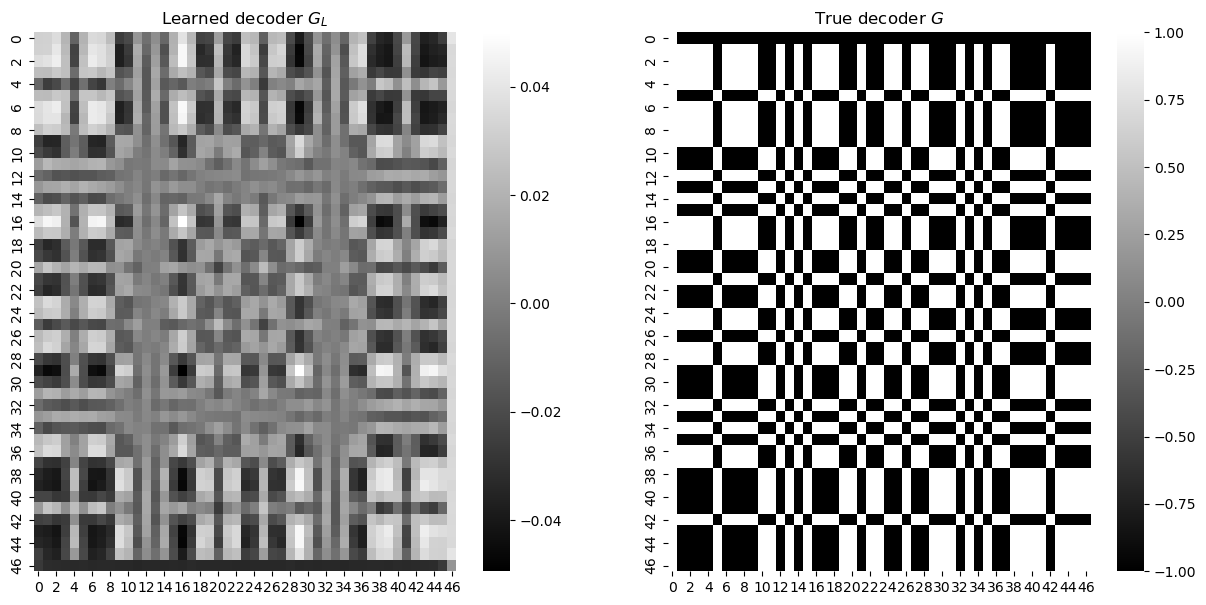

In [16]:
## Plot weights
print(model.RUN_DIR)
# ----------- Plot learned weights and target weights---- 
# From Jacky's SAR stuff
# Define initial weights from the CNN model
init_weights = list(model.parameters())
init_weight_map = init_weights[0].detach()
print('Initial weights Shape: {}'.format(init_weight_map[0].shape))

fig, axs = plt.subplots(1,2, figsize=(15,7))
axs = axs.ravel()
sns.heatmap(np.squeeze(init_weight_map.cpu().numpy()), cmap='gray', ax= axs[0])
sns.heatmap(target_weights, cmap='gray', ax= axs[1])
axs[0].set_title("Learned decoder $G_L$")
axs[1].set_title("True decoder $G$")
plt.show()

# Test set evaluation

In [18]:
from torchmetrics.image import StructuralSimilarityIndexMeasure 

In [19]:
SSIM = StructuralSimilarityIndexMeasure()

In [20]:
# This is to load test sets with different levels of noise. Change level of noise
model.params['snr'] = 1

# Define transforms 
train_transform_list =[transforms.Grayscale(),
                       transforms.ToTensor(),
                       transforms.Resize(params['image_size'], antialias=True), 
                      ]
# For noiseless data, just normalize values between [0,1]
# If noise, add desired SNR noise
if model.params.get('snr') is None: 
    train_transform_list.append(Normalize_01())
else:
    train_transform_list.append(Noise_dB(desired_snr=model.params['snr']))
    train_transform_list.append(Normalize_01())

train_transform = transforms.Compose(train_transform_list)
target_transform = transforms.Compose(
            [   transforms.Grayscale(),
                transforms.ToTensor(),
                transforms.Resize((params['image_size'],params['image_size']), antialias=True),
                Normalize_01(),
                ])

# Define test set
test_mnist_mura = MNIST_MURA('../data/MNIST/', params, transform=train_transform, target_transform=target_transform, train=False)
testset = DataLoader(test_mnist_mura, batch_size=1, shuffle=True)

#Fashion MNOST
# test_fashion_mura = FashionMURA('../data/FashionMNIST/',  params, transform=train_transform, target_transform=target_transform, train=False)
# testset = DataLoader(test_fashion_mura, batch_size=10, shuffle=True)

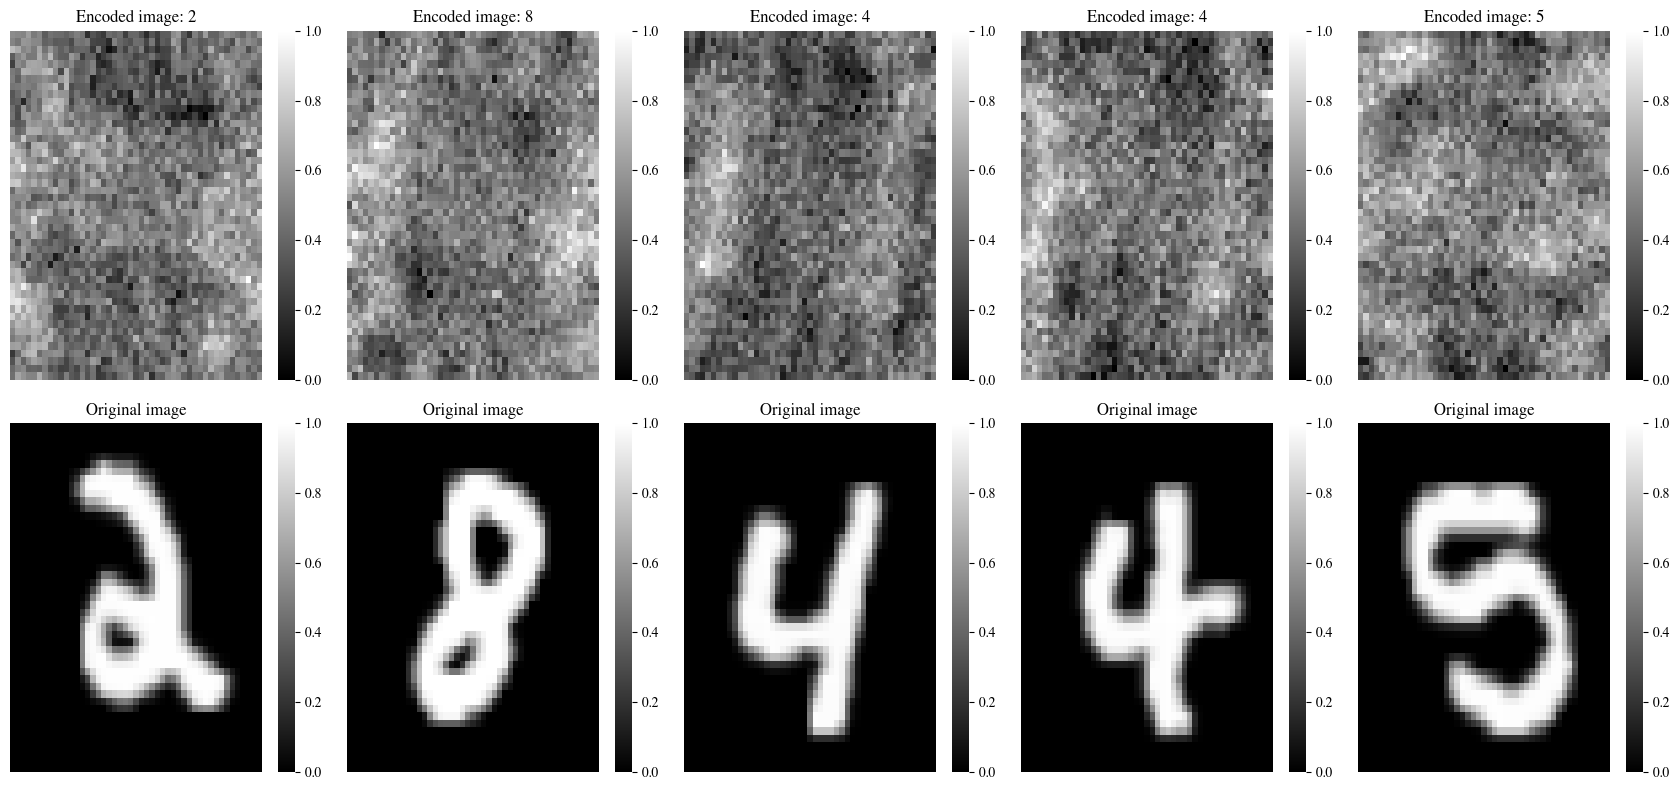

In [21]:
# Change plotting parameters
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Times", #"Computer Modern Serif"
    "figure.figsize" : [17,8],
})
# Printing 25 random images from the test dataset
random_samples = np.random.randint(1, len(testset), (5))
count = 0
for idx in random_samples: #range(random_samples.shape[0]):
    plt.subplot(2, 5, count + 1)
    sns.heatmap(testset.dataset[idx]['img'].squeeze(0), cmap='gray')
    plt.title(f'Encoded image: {testset.dataset[idx]["digit"]}')
    plt.axis('off')
    plt.subplot(2, 5, count + 6)
    sns.heatmap(testset.dataset[idx]['target'].squeeze(0), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    
    count += 1
plt.tight_layout()
# plt.savefig(RUN_DIR+ f"encoded_examples_snr_{model.params['snr']}.png")
plt.show()

# Calculate results with model

In [29]:
# Save MSE and SSIM evaluations in list
results = []
for i, data in enumerate(testset):
    inputs, targets, digits = data['img'], data['target'], data['digit']
    outputs = model(inputs.to(device))
    mse_loss = model.criterion(outputs, targets)
    ssim_loss = SSIM(outputs, targets)
    results.append((inputs, outputs, targets, digits, mse_loss.item(), ssim_loss.item(), model.params['snr']))
    # show_outputs(outputs, targets, inputs, iterator=i)

(array([ 23., 100., 190., 117.,  39.,  15.,   9.,  18.,  13.,   5.]),
 array([-0.25327799, -0.11269116,  0.02789566,  0.1684825 ,  0.30906931,
         0.44965613,  0.59024298,  0.73082978,  0.87141663,  1.01200342,
         1.15259027]),
 <BarContainer object of 10 artists>)

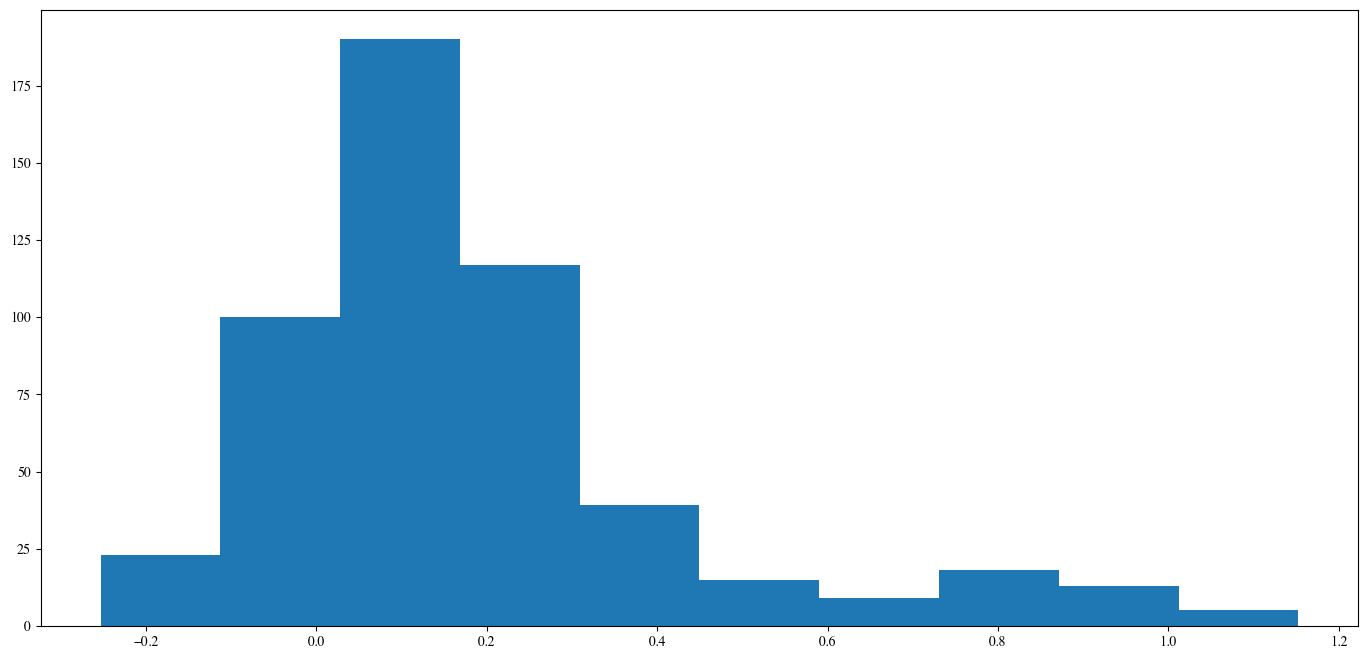

In [37]:
plt.hist(outputs.view(-1).detach())

/var/folders/c_/ryp6y6k53ss049db0ng9scw80000gn/T/ipykernel_7729/2925867715.py:3: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.

/var/folders/c_/ryp6y6k53ss049db0ng9scw80000gn/T/ipykernel_7729/2925867715.py:7: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



ValueError: num must be an integer with 1 <= num <= 15, not 16

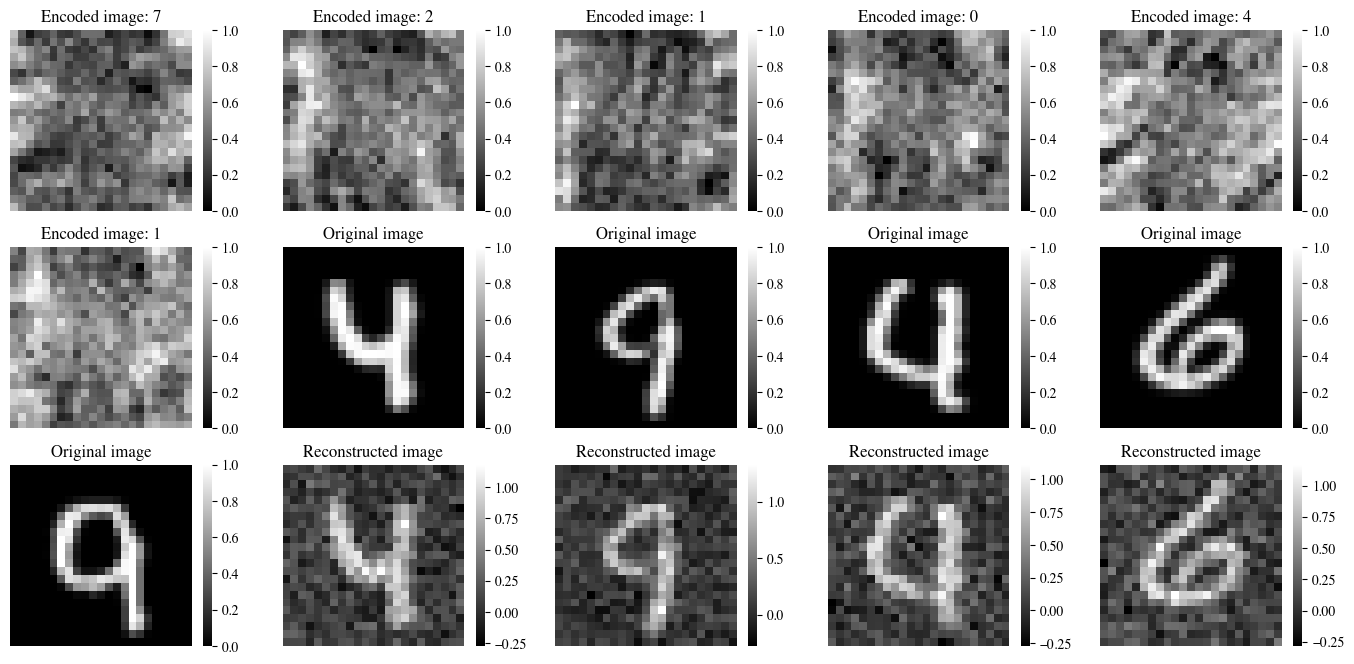

In [22]:
count = 0
for idx in range(outputs.shape[0]):
    plt.subplot(3, 5, count + 1)
    sns.heatmap(inputs[idx].squeeze(0).detach(), cmap='gray')
    plt.title(f'Encoded image: {testset.dataset[idx]["digit"]}')
    plt.axis('off')
    plt.subplot(3, 5, count + 6)
    sns.heatmap(targets[idx].squeeze(0), cmap='gray')
    plt.title('Original image')
    plt.axis('off')
    plt.subplot(3, 5, count + 11)
    sns.heatmap(outputs[idx].squeeze(0).detach(), cmap='gray')
    plt.title('Reconstructed image')
    plt.axis('off')
        
    count += 1
plt.tight_layout()

In [23]:
# Put results in dataframe
df = pd.DataFrame(results, columns=['inputs', 'outputs', 'targets', 'digits', 'mse', 'ssim','snr'])
df.head(5)

,inputs,outputs,targets,digits,mse,ssim,snr
0,"[[[tensor([0.4385, 0.2696, 0.5847, 0.6409, 0.4...","[[[tensor([ 0.1958, 0.0170, 0.2053, 0.1137,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(2), tensor(9), tensor(2), tensor(9), t...",NaN,NaN,5
1,"[[[tensor([0.4069, 0.5169, 0.4944, 0.5227, 0.5...","[[[tensor([ 0.1860, -0.0683, -0.0857, 0.1671,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(1), tensor(1), tensor(6), tensor(1), t...",0.028675,0.736043,5
2,"[[[tensor([0.4836, 0.4384, 0.3158, 0.4018, 0.3...","[[[tensor([ 0.0252, 0.1965, 0.2114, 0.0207,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(1), tensor(1), tensor(4), tensor(9), t...",NaN,NaN,5
3,"[[[tensor([0.5724, 0.6189, 0.3549, 0.3759, 0.2...","[[[tensor([-0.0135, 0.1070, 0.1757, 0.3381,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(6), tensor(6), tensor(8), tensor(1), t...",0.026329,0.746621,5
4,"[[[tensor([0.6285, 0.6395, 0.6844, 0.5249, 0.3...","[[[tensor([ 0.2612, 0.0586, 0.1118, -0.0674,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(8), tensor(7), tensor(1), tensor(2), t...",NaN,NaN,5


In [24]:
df.sort_values(by='ssim', ascending=True)

,inputs,outputs,targets,digits,mse,ssim,snr
26,"[[[tensor([0.0905, 0.0406, 0.2856, 0.5207, 0.4...","[[[tensor([ 0.1516, 0.0907, -0.0185, 0.2230,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(4), tensor(2), tensor(3), tensor(4), t...",0.027366,0.728785,5
25,"[[[tensor([0.3437, 0.4943, 0.6722, 0.4320, 0.5...","[[[tensor([ 0.2741, 0.0169, -0.0640, 0.1668,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(2), tensor(4), tensor(7), tensor(9), t...",0.026817,0.730178,5
67,"[[[tensor([0.4357, 0.4040, 0.4416, 0.4302, 0.5...","[[[tensor([ 0.0657, 0.3519, -0.0453, 0.2244,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(5), tensor(0), tensor(5), tensor(8), t...",0.027019,0.731029,5
81,"[[[tensor([0.2014, 0.3003, 0.5716, 0.8192, 0.8...","[[[tensor([ 0.0707, 0.0758, 0.2233, 0.0921,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(1), tensor(9), tensor(9), tensor(7), t...",0.027921,0.732549,5
51,"[[[tensor([0.5703, 0.4055, 0.5639, 0.6193, 0.4...","[[[tensor([ 2.6083e-01, 1.7525e-01, 1.1888e-...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(0), tensor(4), tensor(6), tensor(6), t...",0.027055,0.735351,5
...,...,...,...,...,...,...,...
4,"[[[tensor([0.6285, 0.6395, 0.6844, 0.5249, 0.3...","[[[tensor([ 0.2612, 0.0586, 0.1118, -0.0674,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(8), tensor(7), tensor(1), tensor(2), t...",NaN,NaN,5
5,"[[[tensor([0.2694, 0.5262, 0.5386, 0.7154, 0.4...","[[[tensor([ 0.0293, -0.0773, 0.0397, 0.1741,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(1), tensor(0), tensor(0), tensor(7), t...",NaN,NaN,5
6,"[[[tensor([0.5031, 0.4961, 0.4296, 0.4893, 0.4...","[[[tensor([ 0.0847, -0.1123, 0.1823, 0.0814,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(0), tensor(9), tensor(8), tensor(8), t...",NaN,NaN,5
7,"[[[tensor([0.8871, 0.7892, 0.6013, 0.5598, 0.2...","[[[tensor([ 0.2027, -0.0289, 0.5109, -0.0402,...","[[[tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.,...","[tensor(7), tensor(8), tensor(4), tensor(9), t...",NaN,NaN,5


In [ ]:
sns.heatmap(df.sort_values(by='ssim', ascending=True).iloc[1]['outputs'].squeeze(0).squeeze(0).detach()); plt.show()
sns.heatmap(df.sort_values(by='ssim', ascending=True).iloc[1]['targets'].squeeze(0).squeeze(0).detach());plt.show()

# Plot results

In [25]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
# pio.renderers.default = 'notebook'

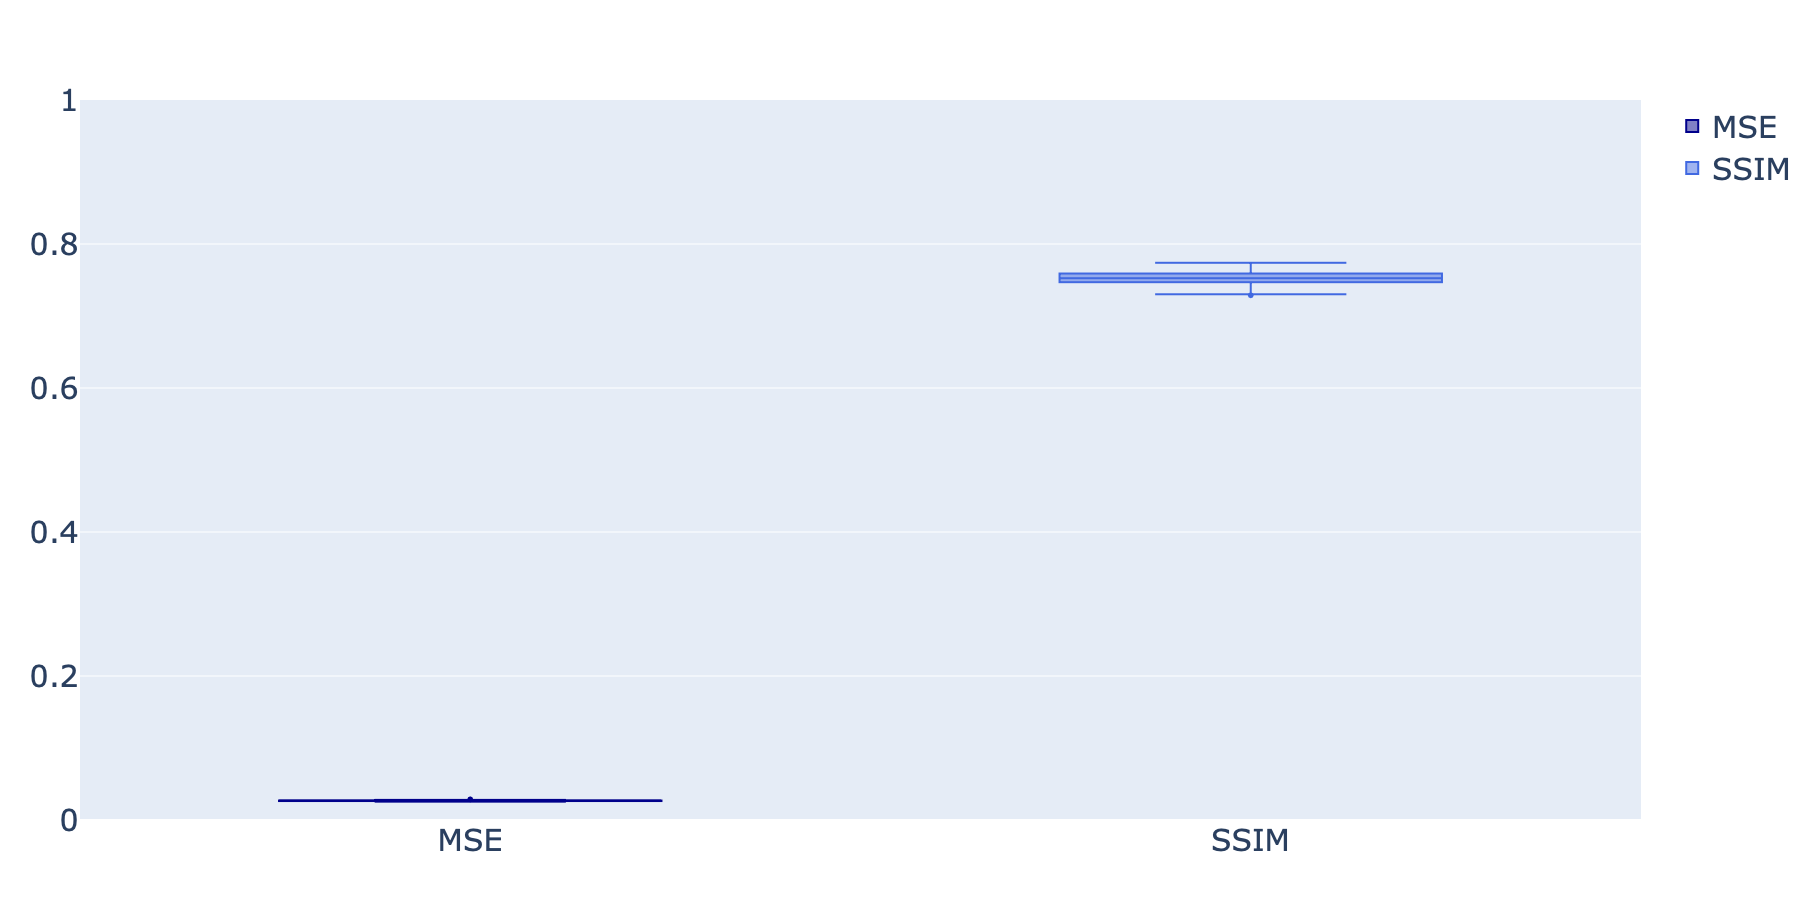

In [26]:
y0 = df.mse
y1 = df.ssim

fig = go.Figure()
fig.add_trace(go.Box(y=y0, name='MSE',
                marker_color = 'darkblue'))
fig.add_trace(go.Box(y=y1, name = 'SSIM',
                marker_color = 'royalblue'))
fig.update_layout(
    autosize=False,
    width=1200,
    height=900,
    yaxis=dict(
        # title_text="Y-axis Title",
        # ticktext=["Very long label", "long label", "3", "label"],
        # tickvals=,
        tickmode="array",
        titlefont=dict(size=30),
    ),
    yaxis_range=[0,1],
    font=dict(size=30),
)
fig.show(renderer="jupyterlab")
# fig.write_image(RUN_DIR + f'boxplot_metrics_snr_{model.params["snr"]}.png')

# Deconvolution method

In [23]:
D = testset.dataset[10]['img']
fft_D = torch.fft.fft2(D.squeeze(0))
fft_A = torch.fft.fft2(torch.Tensor(train_data.A))
invert = torch.fft.ifft2(fft_D/fft_A)
# recenter = torch.roll(invert, [int((model.img_size+1)/2),int((model.img_size+1)/2)], dims=(0,1))
recenter = torch.roll(invert, [round((model.img_size-1)/2),round((model.img_size-1)/2)], dims=(0,1))

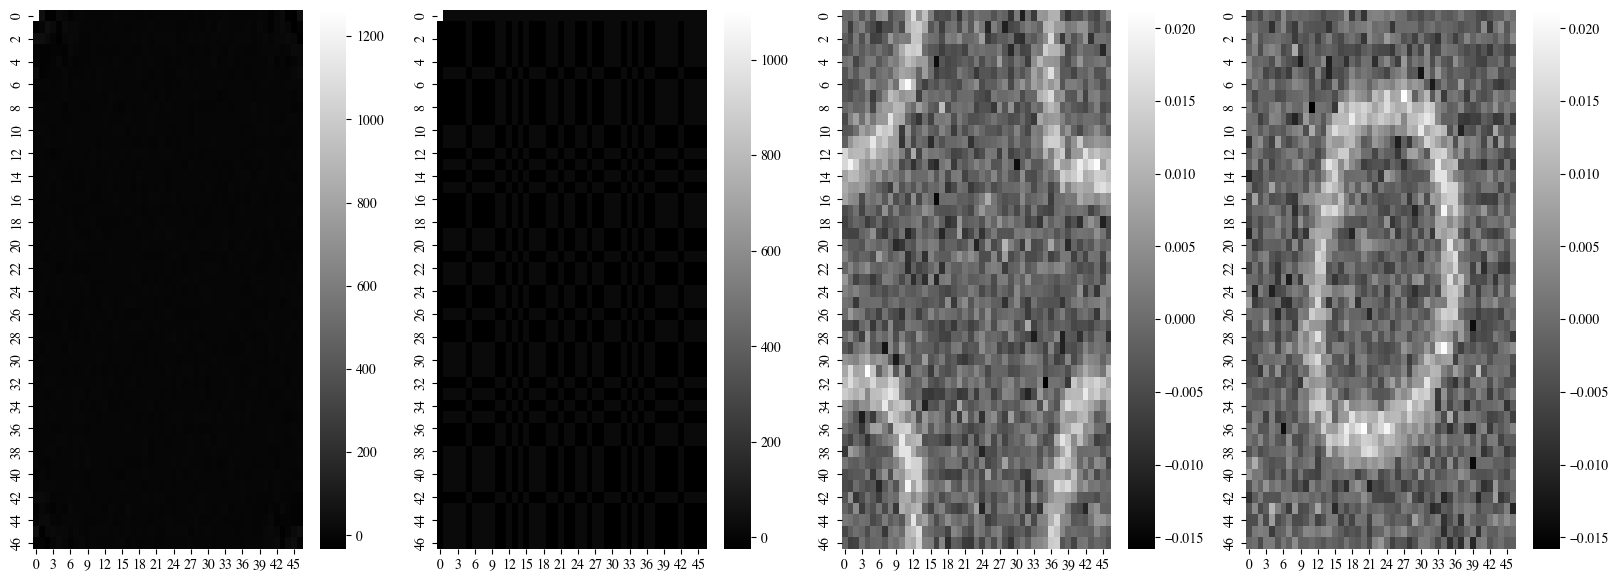

In [24]:
fig, axs = plt.subplots(1,4, figsize= (20,7))
axs = axs.ravel()
sns.heatmap(fft_D.real, ax=axs[0], cmap='gray')
sns.heatmap(fft_A.real, ax=axs[1], cmap='gray')
sns.heatmap(invert.real, ax=axs[2], cmap='gray')
sns.heatmap(recenter.real, ax=axs[3], cmap='gray')
plt.show()

# Rotate the weights

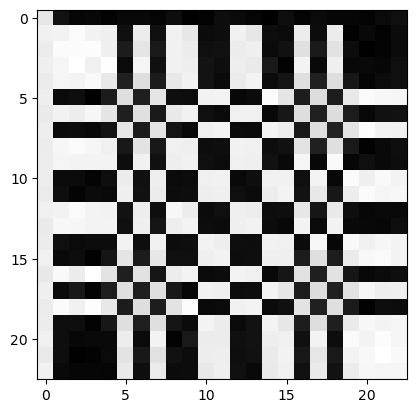

In [42]:
# Rotate the weights 180 degrees
w_rot90 = torch.rot90(torch.Tensor(weight_map), 1, [0, 1])
w_rot180 = torch.rot90(w_rot90, 1, [0, 1])
plt.imshow(w_rot180, cmap='gray')

In [28]:
padded_ex = torch.nn.functional.pad(loaders['train'].dataset[idx]['target'].unsqueeze(0), pad=(11,11,11,11), mode='circular')
padded_ex = padded_ex.squeeze(0).squeeze(0)

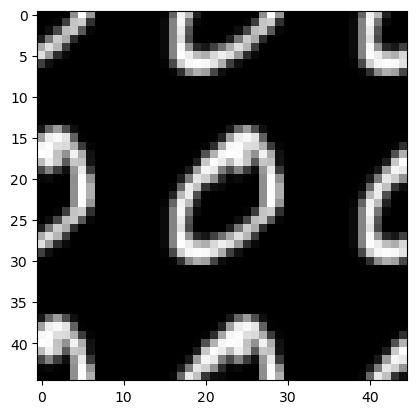

In [34]:
plt.imshow(padded_ex, cmap='gray')
plt.show()